
# Deep Learning Homework 6 (Spring 2023)

This code is provided for Deep Learning class (601.482/682) Homework 6. For ease of implementation, we recommend working entire in Google Colaboratory.

@Copyright Cong Gao, the Johns Hopkins University, cgao11@jhu.edu. Modifications made by Hongtao Wu, Suzanna Sia, Hao Ding, Keith Harrigian, and Yiqing Shen.


### Imports

In [ ]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


In [ ]:
## Standard Library
import os
import json

## External Libraries
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt
import copy

# Problem 1: Unsupervised Pre-training

### Training Hyperparameters

These are recommended hyperparameters - please feel free to use what works for you. Batch size can be changed if it does not match your memory, please state your batch step_size in your report.

Dataset is available at: https://livejohnshopkins-my.sharepoint.com/:u:/g/personal/yshen92_jh_edu/EcTxWAXsAhtDiv3vUxCTF8gBgAARCUvvKthb3s-pEExyMg

In [ ]:
## Batch Size
train_batch_size = 10
validation_batch_size = 10

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data Paths

In [ ]:
# General Data Directory ##TODO: Please fill in the appropriate directory
data_dir = "/content/gdrive/MyDrive/Colab_Notebooks/HW6_data"

## Segmentation + Colorization Paths
segmentation_data_dir = f"{data_dir}/segmentation/"
colorization_data_dir = f"{data_dir}/colorization/"

# Mask JSON
mask_json = f"{data_dir}/mapping.json"

### Data Loaders

We have provided you with some preprocessing code for the images but you should feel free to modify the class however you please to support your training schema. In the very least, you will have to modify the dataloader to support loading of the colorization dataset.

In [ ]:
## Image Transforms
img_transform = transforms.Compose([
        transforms.ToTensor(),
])

## Image Dataloader
class ImageDataset(Dataset):
    
    """
    ImageDataset
    """
    
    def __init__(self,
                 input_dir,
                 op,
                 mask_json_path,
                 transforms=None):
        """
        ##TODO: Add support for colorization dataset
        
        Args:
            input_dir (str): Path to either colorization or segmentation directory
            op (str): One of "train", "val", or "test" signifying the desired split
            mask_json_path (str): Path to mapping.json file
            transforms (list or None): Image transformations to apply upon loading.
        """
        self.transform = transforms
        self.op = op
        with open(mask_json_path, 'r') as f:
            self.mask = json.load(f)
        self.mask_num = len(self.mask)  # There are 6 categories: grey, dark grey, and black
        self.mask_value = [value for value in self.mask.values()]
        self.mask_value.sort()
        try:
            if self.op == 'train':
                self.data_dir = os.path.join(input_dir, 'train')
            elif self.op == 'val':
                self.data_dir = os.path.join(input_dir, 'validation')
            elif self.op == 'test':
                self.data_dir = os.path.join(input_dir, 'test')
        except ValueError:
            print('op should be either train, val or test!')

    def __len__(self):
        """
        
        """
        return len(next(os.walk(self.data_dir))[1])

    def __getitem__(self,
                    idx):
        """
        
        """
        ## Load Image and Parse Properties
        img_name = str(idx) + '_input.jpg'
        mask_name = str(idx) + '_mask.png'
        img = io.imread(os.path.join(self.data_dir, str(idx), img_name))
        mask = io.imread(os.path.join(self.data_dir, str(idx), mask_name))
        if len(mask.shape) == 2:
            h, w  = mask.shape
        elif len(mask.shape) == 3:
            h, w, c = mask.shape
        ## Convert grey-scale label to one-hot encoding
        new_mask = np.zeros((h, w, self.mask_num))
        for idx in range(self.mask_num):
            #if the mask has 3 dimension use this code
            new_mask[:, :, idx] = mask[:,:,0] == self.mask_value[idx]
            #if the mask has 1 dimension use the code below
            #new_mask[:, :, idx] = mask == self.mask_value[idx]
        ## Transform image and mask
        if self.transform:
            #new_mask = torch.from_numpy(new_mask).long().to(device)
            img, mask = self.img_transform(img, new_mask)
        # ## Use dictionary to output
        # sample = {'img': img, 'mask': mask}
        # return sample
        return img, mask

    def img_transform(self,
                      img,
                      mask):
        """
        
        """
        ## Apply Transformations to Image and Mask
        img = self.transform(img)
        mask = self.transform(mask)

        return img, mask

In [ ]:
import torchvision.transforms.functional as TF
import random
## Image Transforms
img_transform = transforms.Compose([
        transforms.ToTensor(),
])

class Aug_ImageDataset(Dataset):
    
    """
    ImageDataset
    """
    
    def __init__(self,
                 input_dir,
                 op,
                 mask_json_path,
                 transforms=None):
        """
        ##TODO: Add support for colorization dataset
        
        Args:
            input_dir (str): Path to either colorization or segmentation directory
            op (str): One of "train", "val", or "test" signifying the desired split
            mask_json_path (str): Path to mapping.json file
            transforms (list or None): Image transformations to apply upon loading.
        """
        self.transform = transforms
        self.op = op
        with open(mask_json_path, 'r') as f:
            self.mask = json.load(f)
        self.mask_num = len(self.mask)  # There are 6 categories: grey, dark grey, and black
        self.mask_value = [value for value in self.mask.values()]
        self.mask_value.sort()
        try:
            if self.op == 'train':
                self.data_dir = os.path.join(input_dir, 'train')
            elif self.op == 'val':
                self.data_dir = os.path.join(input_dir, 'validation')
            elif self.op == 'test':
                self.data_dir = os.path.join(input_dir, 'test')
        except ValueError:
            print('op should be either train, val or test!')

    def __len__(self):
        """
        
        """
        return len(next(os.walk(self.data_dir))[1])

    def __getitem__(self,
                    idx):
        """
        
        """
        ## Load Image and Parse Properties
        img_name = str(idx) + '_input.jpg'
        mask_name = str(idx) + '_mask.png'
        img = io.imread(os.path.join(self.data_dir, str(idx), img_name))
        mask = io.imread(os.path.join(self.data_dir, str(idx), mask_name))
        if len(mask.shape) == 2:
            h, w  = mask.shape
        elif len(mask.shape) == 3:
            h, w, c = mask.shape
        ## Convert grey-scale label to one-hot encoding
        new_mask = np.zeros((h, w, self.mask_num))
        for idx in range(self.mask_num):
            #if the mask has 3 dimension use this code
            new_mask[:, :, idx] = mask[:,:,0] == self.mask_value[idx]
            #if the mask has 1 dimension use the code below
            #new_mask[:, :, idx] = mask == self.mask_value[idx]
        ## Transform image and mask
        if self.transform:
            #new_mask = torch.from_numpy(new_mask).long().to(device)
            img, mask = self.img_transform(img, new_mask)
        # ## Use dictionary to output
        # sample = {'img': img, 'mask': mask}
        # return sample
        return img, mask

    def img_transform(self,
                      img,
                      mask):
        """
        
        """
        img = self.transform(img)
        mask = self.transform(mask)
        if self.op == 'train':
            if random.random() > 0.5:
                img = TF.hflip(img)
                mask = TF.hflip(mask) 
            if random.random() > 0.5:
                img = TF.vflip(img)
                mask = TF.vflip(mask)

        return img, mask

## Model Architecture

Finish building the U-net architecture below.

In [ ]:
## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   bias=True,
                   useBN=True):
    """
    
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

## Upsampling
def upsample(ch_coarse,
             ch_fine):
    """
    
    """
    return nn.Sequential(
                    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False), #in_channels, out_channels, kernel_size, stride, padding
                    nn.ReLU())


# U-Net
class UNET(nn.Module):
    
    """
    
    """
    def __init__(self, n_classes, useBN=True):
        """
        Args:
            n_classes (int): Number of classes
            useBN (bool): Turn Batch Norm on or off. (Hint: Using BatchNorm might help you achieve better performance.)
        """
        super(UNET, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
                    
        self.output = nn.Conv2d(in_channels = 32, out_channels = n_classes, kernel_size=3, stride=1, padding=1)
        


    def forward(self, x):
        """
        Forward pass
        """
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        output_layer = self.output(conv1m_out)
        #TODO: Design your last layer & activations

        return torch.nn.functional.softmax(output_layer, 1)


### DICE Score and DICE Loss

Finish implementing the DICE score function below and then write a Dice Loss function that you can use to update your model weights.

In [ ]:
##TODO: Finish implementing the multi-class DICE score function
def dice_score_image(prediction, target, n_classes):
    '''
      computer the mean dice score for a single image

      Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
      Args:
          prediction (tensor): predictied labels of the image
          target (tensor): ground truth of the image
          n_classes (int): number of classes
    
      Returns:
          m_dice (float): Mean dice score over classes
    '''
    ## Should test image one by one
    assert prediction.shape[0] == 1 #This line can not be deleted
    
    ## TODO: Compute Dice Score for Each Class. Compute Mean Dice Score over Classes.
    pred_OHE = torch.zeros(target.shape).to(device)
    prediction = prediction.type(torch.int64)
    pred_OHE.scatter_(1, prediction, 1)
    # if use_gpu:
    #     pred_OHE = pred_OHE.cuda()
    dice_classes = np.zeros(n_classes)
    for cl in range(n_classes):
        y_true_f = target[:, cl, :, :].flatten()
        y_pred_f = pred_OHE[:, cl, :, :].flatten()
        intersection = torch.sum(y_true_f * y_pred_f)
        true_label_norm = torch.sum(y_true_f) # targe label (ground truth)
        pred_label_norm = torch.sum(y_pred_f) # predict label

        #When there is no grount truth of the class in this image
        #Give 1 dice score if False Positive pixel number is 0, 
        #give 0 dice score if False Positive pixel number is not 0 (> 0).
        score = 0
        if true_label_norm == 0: # no ground truth
            if pred_label_norm == 0: # no false positive
                score = 1
            else:                    # has false positive
                score = 0 
        else:
            score = (2*intersection)/(true_label_norm + pred_label_norm) 
        dice_classes[cl] = score
    return dice_classes.mean()



def dice_score_dataset(model, dataloader, num_classes, use_gpu=False):
    """
    Compute the mean dice score on a set of data.
    
    Note that multiclass dice score can be defined as the mean over classes of binary
    dice score. Dice score is computed per image. Mean dice score over the dataset is the dice
    score averaged across all images.
    
    Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
     
    Args:
        model (UNET class): Your trained model
        dataloader (DataLoader): Dataset for evaluation
        num_classes (int): Number of classes
    
    Returns:
        m_dice (float): Mean dice score over the input dataset
    """
    ## Number of Batches and Cache over Dataset 
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)
    ## Evaluate
    model.eval()
    idx = 0
    for data in dataloader:
        ## Format Data
        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        ## Make Predictions
        out = model(img)
        n_classes = out.shape[1]
        #prediction = torch.argmax(out, dim = 1)
        prediction = torch.argmax(out, 1, keepdim=True)
        scores[idx] = dice_score_image(prediction, target, n_classes)
        idx += 1
    ## Average Dice Score Over Images
    m_dice = scores.mean()
    return m_dice


## TODO: Implement DICE loss, 
#  It should conform to to how we computer the dice score.
class DICELoss(nn.Module):
    def __init__(self, n_classes, smooth = 0.01):
        super(DICELoss, self).__init__()
        self.n_classes = n_classes
        self.smooth = smooth
    
    def forward(self, prediction, target):
        total_loss = 0
        for i in range(target.size(0)):
            total_score = 0
            for cl in range(self.n_classes):
                y_true_f = target[i, cl, :, :].flatten()
                y_pred_f = prediction[i, cl, :, :].flatten()
                intersection_prob = torch.sum(y_true_f * y_pred_f) # intersection
                true_label_prob = torch.sum(y_true_f * y_true_f) # targe label (ground truth)
                pred_label_prob = torch.sum(y_pred_f * y_pred_f) # predict label
                if true_label_prob == 0:
                    if pred_label_prob == 0:
                        total_score += 1
                else:
                    total_score += (2*intersection_prob + self.smooth)/(true_label_prob + pred_label_prob + self.smooth)
            total_loss += 1-(total_score/self.n_classes)
        return total_loss/target.size(0)

## Training Procedure (Segmentation)

For 6 classes without data augmentation

In [ ]:
## Initialize your unet
n_classes = 6
model = UNET(n_classes)
model.to(device)
loss = DICELoss(n_classes)

## Initialize Dataloaders
train_dataset=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=img_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Best_model_index = 1
Best_model_val_loss = np.inf
Best_model = None
train_loss_list = []
val_loss_list = []
print("Start Training...")
for epoch in range(num_epochs):
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    ########################### Training #####################################
    total_train_loss = 0
    train_counter = 0
    for i, (X, Y) in enumerate(train_dataloader):
        train_counter += 1
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        Y_pred = model(X)
        ls = loss(Y_pred, Y)
        ls.backward()
        optimizer.step()
        total_train_loss += ls.item()
    train_loss_list.append(total_train_loss/train_counter)
    print("Training Loss: {:.4f}".format(total_train_loss/train_counter))

    ########################### Validation #####################################
    total_val_loss = 0
    val_counter = 0
    with torch.no_grad():
        for i, (X, Y) in enumerate(validation_dataloader):
            val_counter += 1
            X = X.to(device)
            Y = Y.to(device)
            Y_pred = model(X)
            ls = loss(Y_pred, Y)
            total_val_loss += ls.item()
        epoch_val_loss = total_val_loss/val_counter
        val_loss_list.append(epoch_val_loss)
        print("Validation Loss: {:.4f}".format(epoch_val_loss))
        if epoch_val_loss < Best_model_val_loss:
            Best_model_val_loss = epoch_val_loss
            Best_model_index = epoch
            Best_model = copy.deepcopy(model)
        print('Current Best Model: Epoch {}, Best Validation Loss {:.4f}'.format(Best_model_index, Best_model_val_loss))

Start Training...

EPOCH 1 of 200

Training Loss: 0.7603
Validation Loss: 0.7189
Current Best Model: Epoch 0, Best Validation Loss 0.7189

EPOCH 2 of 200

Training Loss: 0.7023
Validation Loss: 0.7299
Current Best Model: Epoch 0, Best Validation Loss 0.7189

EPOCH 3 of 200

Training Loss: 0.6897
Validation Loss: 0.7148
Current Best Model: Epoch 2, Best Validation Loss 0.7148

EPOCH 4 of 200

Training Loss: 0.6822
Validation Loss: 0.7004
Current Best Model: Epoch 3, Best Validation Loss 0.7004

EPOCH 5 of 200

Training Loss: 0.6663
Validation Loss: 0.7021
Current Best Model: Epoch 3, Best Validation Loss 0.7004

EPOCH 6 of 200

Training Loss: 0.6623
Validation Loss: 0.6872
Current Best Model: Epoch 5, Best Validation Loss 0.6872

EPOCH 7 of 200

Training Loss: 0.6567
Validation Loss: 0.6778
Current Best Model: Epoch 6, Best Validation Loss 0.6778

EPOCH 8 of 200

Training Loss: 0.6492
Validation Loss: 0.6891
Current Best Model: Epoch 6, Best Validation Loss 0.6778

EPOCH 9 of 200

Train

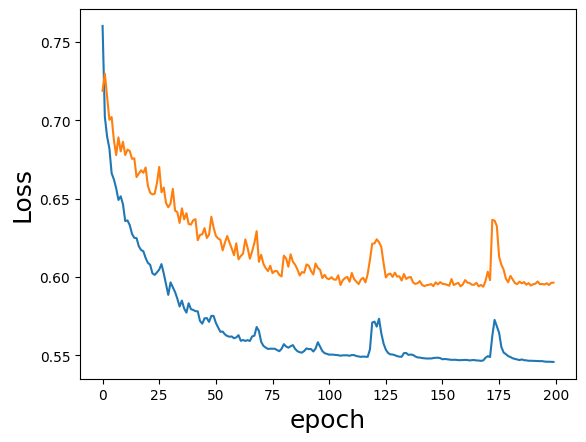

In [ ]:
#Plots
fig0=plt.figure(0)
plt.plot(train_loss_list,'-')
plt.plot(val_loss_list, '-')
plt.xlabel('epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()
#print(train_loss_list)

In [ ]:
test_score = dice_score_dataset(Best_model, test_dataloader, n_classes, use_gpu=True)
print("Test DICE score: {:.4f}".format(test_score))

Test DICE score: 0.6119


For 6 classes with hflip and vflip prob = 0.5

In [ ]:
## Initialize your unet
n_classes = 6
model = UNET(n_classes)
model.to(device)
loss = DICELoss(n_classes)

## Initialize Dataloaders
train_dataset=Aug_ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=img_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Best_model_index = 1
Best_model_val_loss = np.inf
Best_model = None
train_loss_list = []
val_loss_list = []
print("Start Training...")
for epoch in range(num_epochs):
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    ########################### Training #####################################
    total_train_loss = 0
    train_counter = 0
    for i, (X, Y) in enumerate(train_dataloader):
        train_counter += 1
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        Y_pred = model(X)
        ls = loss(Y_pred, Y)
        ls.backward()
        optimizer.step()
        total_train_loss += ls.item()
    train_loss_list.append(total_train_loss/train_counter)
    print("Training Loss: {:.4f}".format(total_train_loss/train_counter))

    ########################### Validation #####################################
    total_val_loss = 0
    val_counter = 0
    with torch.no_grad():
        for i, (X, Y) in enumerate(validation_dataloader):
            val_counter += 1
            X = X.to(device)
            Y = Y.to(device)
            Y_pred = model(X)
            ls = loss(Y_pred, Y)
            total_val_loss += ls.item()
        epoch_val_loss = total_val_loss/val_counter
        val_loss_list.append(epoch_val_loss)
        print("Validation Loss: {:.4f}".format(epoch_val_loss))
        if epoch_val_loss < Best_model_val_loss:
            Best_model_val_loss = epoch_val_loss
            Best_model_index = epoch
            Best_model = copy.deepcopy(model)
        print('Current Best Model: Epoch {}, Best Validation Loss {:.4f}'.format(Best_model_index, Best_model_val_loss))

Start Training...

EPOCH 1 of 200

Training Loss: 0.7580
Validation Loss: 0.7192
Current Best Model: Epoch 0, Best Validation Loss 0.7192

EPOCH 2 of 200

Training Loss: 0.7095
Validation Loss: 0.7099
Current Best Model: Epoch 1, Best Validation Loss 0.7099

EPOCH 3 of 200

Training Loss: 0.6986
Validation Loss: 0.7186
Current Best Model: Epoch 1, Best Validation Loss 0.7099

EPOCH 4 of 200

Training Loss: 0.6865
Validation Loss: 0.7118
Current Best Model: Epoch 1, Best Validation Loss 0.7099

EPOCH 5 of 200

Training Loss: 0.6895
Validation Loss: 0.7067
Current Best Model: Epoch 4, Best Validation Loss 0.7067

EPOCH 6 of 200

Training Loss: 0.6817
Validation Loss: 0.7221
Current Best Model: Epoch 4, Best Validation Loss 0.7067

EPOCH 7 of 200

Training Loss: 0.6807
Validation Loss: 0.6962
Current Best Model: Epoch 6, Best Validation Loss 0.6962

EPOCH 8 of 200

Training Loss: 0.6740
Validation Loss: 0.6968
Current Best Model: Epoch 6, Best Validation Loss 0.6962

EPOCH 9 of 200

Train

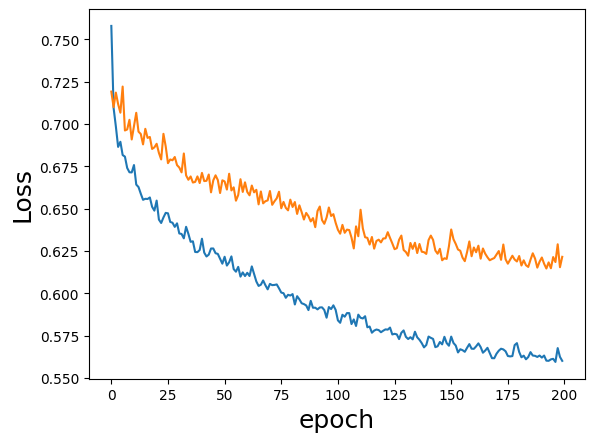

In [ ]:
#Plots
fig0=plt.figure(0)
plt.plot(train_loss_list,'-')
plt.plot(val_loss_list, '-')
plt.xlabel('epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

In [1]:
test_score = dice_score_dataset(Best_model, test_dataloader, n_classes, use_gpu=True)
print("Test DICE score: {:.4f}".format(test_score))

Test DICE score: 0.6305


## Training Procedure: Colorization Pre-training

Complete the rest of this problem in the cells below.

In [ ]:
## Batch Size
train_batch_size = 7
validation_batch_size = 7

## Learning Rate
learning_rate = 0.00005

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50


In [ ]:
## Image Transforms
img_transform = transforms.Compose([
        transforms.ToTensor(),
])
import cv2

## Image Dataloader
class Col_ImageDataset(Dataset):
    
    """
    ImageDataset
    """
    
    def __init__(self,
                 input_dir,
                 op,
                 transforms=None):
        """
        ##TODO: Add support for colorization dataset
        
        Args:
            input_dir (str): Path to either colorization or segmentation directory
            op (str): One of "train", "val", or "test" signifying the desired split
            mask_json_path (str): Path to mapping.json file
            transforms (list or None): Image transformations to apply upon loading.
        """
        self.transform = transforms
        self.op = op
        #self.expand = transforms.Grayscale(3)
        try:
            if self.op == 'train':
                self.data_dir = os.path.join(input_dir, 'train_cor')
            elif self.op == 'val':
                self.data_dir = os.path.join(input_dir, 'validation_cor')
        except ValueError:
            print('op should be either train, val or test!')

    def __len__(self):
        """
        
        """
        return len(next(os.walk(self.data_dir))[1])

    def __getitem__(self,
                    idx):
        """
        
        """
        if self.op == 'val':
            idx += 1
        ## Load Image and Parse Properties
        img_name = str(idx) + '_gray.jpg'
        mask_name = str(idx) + '_input.jpg'
        img = io.imread(os.path.join(self.data_dir, str(idx), img_name))
        mask = io.imread(os.path.join(self.data_dir, str(idx), mask_name))
        if self.transform:
            img, mask = self.img_transform(img, mask)
        return img, mask

    def img_transform(self,
                      img,
                      mask):
        """
        mask is tensor
        img is np array
        
        """
        ## Apply Transformations to Image and Mask
        #img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        img = self.transform(img)
        mask = self.transform(mask)
        img = img.repeat(3,1,1)

        return img, mask

In [ ]:
## Initialize your unet
n_classes = 3
model = UNET(n_classes)
model.to(device)
loss = nn.MSELoss()

## Initialize Dataloaders
train_dataset=Col_ImageDataset(input_dir=colorization_data_dir, op="train",  transforms = img_transform)
validation_dataset=Col_ImageDataset(input_dir=colorization_data_dir, op="val", transforms =img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Best_model_index = 1
Best_model_val_loss = np.inf
Best_model = None
train_loss_list = []
val_loss_list = []
print("Start Training...")
for epoch in range(num_epochs):
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    ########################### Training #####################################
    total_train_loss = 0
    train_counter = 0
    for i, (X, Y) in enumerate(train_dataloader):
        train_counter += 1
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        Y_pred = model(X)
        ls = loss(Y_pred, Y)
        ls.backward()
        optimizer.step()
        total_train_loss += ls.item()
    train_loss_list.append(total_train_loss/train_counter)
    print("Training Loss: {:.4f}".format(total_train_loss/train_counter))

    ########################### Validation #####################################
    total_val_loss = 0
    val_counter = 0
    with torch.no_grad():
        for i, (X, Y) in enumerate(validation_dataloader):
            val_counter += 1
            X = X.to(device)
            Y = Y.to(device)
            Y_pred = model(X)
            ls = loss(Y_pred, Y)
            total_val_loss += ls.item()
        epoch_val_loss = total_val_loss/val_counter
        val_loss_list.append(epoch_val_loss)
        print("Validation Loss: {:.4f}".format(epoch_val_loss))
        if epoch_val_loss < Best_model_val_loss:
            Best_model_val_loss = epoch_val_loss
            Best_model_index = epoch
            Best_model = copy.deepcopy(model)
        print('Current Best Model: Epoch {}, Best Validation Loss {:.4f}'.format(Best_model_index, Best_model_val_loss))

Start Training...

EPOCH 1 of 50

Training Loss: 0.0372
Validation Loss: 0.0295
Current Best Model: Epoch 0, Best Validation Loss 0.0295

EPOCH 2 of 50

Training Loss: 0.0347
Validation Loss: 0.0290
Current Best Model: Epoch 1, Best Validation Loss 0.0290

EPOCH 3 of 50

Training Loss: 0.0345
Validation Loss: 0.0288
Current Best Model: Epoch 2, Best Validation Loss 0.0288

EPOCH 4 of 50

Training Loss: 0.0344
Validation Loss: 0.0286
Current Best Model: Epoch 3, Best Validation Loss 0.0286

EPOCH 5 of 50

Training Loss: 0.0343
Validation Loss: 0.0289
Current Best Model: Epoch 3, Best Validation Loss 0.0286

EPOCH 6 of 50

Training Loss: 0.0343
Validation Loss: 0.0286
Current Best Model: Epoch 5, Best Validation Loss 0.0286

EPOCH 7 of 50

Training Loss: 0.0342
Validation Loss: 0.0287
Current Best Model: Epoch 5, Best Validation Loss 0.0286

EPOCH 8 of 50

Training Loss: 0.0342
Validation Loss: 0.0284
Current Best Model: Epoch 7, Best Validation Loss 0.0284

EPOCH 9 of 50

Training Loss:

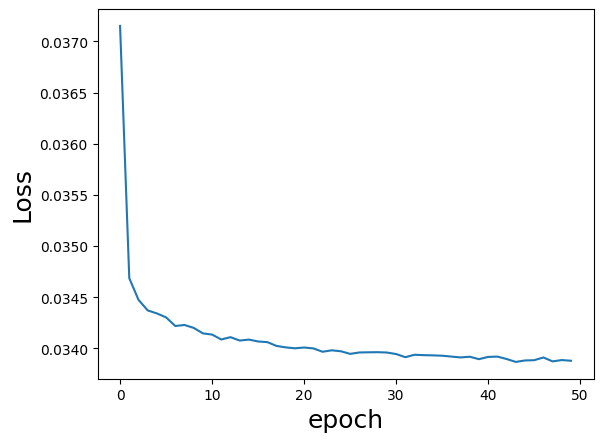

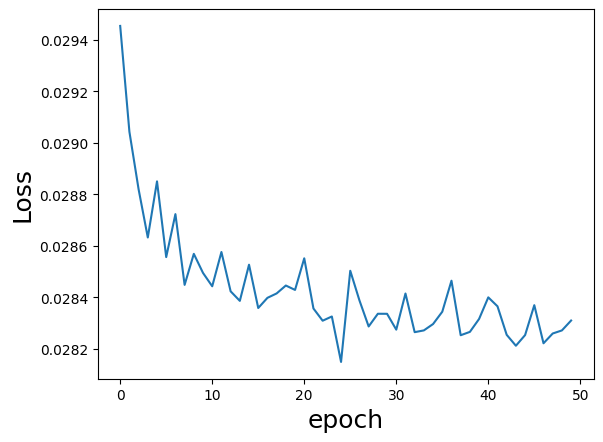

In [ ]:
fig0=plt.figure(0)
plt.plot(train_loss_list,'-')
#plt.plot(val_loss_list, '-')
plt.xlabel('epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()
fig1=plt.figure(1)
plt.plot(val_loss_list, '-')
plt.xlabel('epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

In [ ]:
torch.save(Best_model.state_dict(), "Model_Q1c2.pth")
recol_train_loss = train_loss_list
recol_val_loss = val_loss_list

Retrain UNET in segmentation task

In [ ]:
## Batch Size
train_batch_size = 10
validation_batch_size = 10

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_classes = 6
model = UNET(3)
model.load_state_dict(torch.load("/content/Model_Q1c2.pth"))
model.output = nn.Conv2d(in_channels = 32, out_channels = n_classes, kernel_size=3, stride=1, padding=1)
model.to(device)

loss = DICELoss(n_classes)

## Initialize Dataloaders
train_dataset=Aug_ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=img_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Best_model_index = 1
Best_model_val_loss = np.inf
Best_model = None
train_loss_list = []
val_loss_list = []
print("Start Training...")
for epoch in range(num_epochs):
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    ########################### Training #####################################
    total_train_loss = 0
    train_counter = 0
    for i, (X, Y) in enumerate(train_dataloader):
        train_counter += 1
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        Y_pred = model(X)
        ls = loss(Y_pred, Y)
        ls.backward()
        optimizer.step()
        total_train_loss += ls.item()
    train_loss_list.append(total_train_loss/train_counter)
    print("Training Loss: {:.4f}".format(total_train_loss/train_counter))

    ########################### Validation #####################################
    total_val_loss = 0
    val_counter = 0
    with torch.no_grad():
        for i, (X, Y) in enumerate(validation_dataloader):
            val_counter += 1
            X = X.to(device)
            Y = Y.to(device)
            Y_pred = model(X)
            ls = loss(Y_pred, Y)
            total_val_loss += ls.item()
        epoch_val_loss = total_val_loss/val_counter
        val_loss_list.append(epoch_val_loss)
        print("Validation Loss: {:.4f}".format(epoch_val_loss))
        if epoch_val_loss < Best_model_val_loss:
            Best_model_val_loss = epoch_val_loss
            Best_model_index = epoch
            Best_model = copy.deepcopy(model)
        print('Current Best Model: Epoch {}, Best Validation Loss {:.4f}'.format(Best_model_index, Best_model_val_loss))

Start Training...

EPOCH 1 of 200

Training Loss: 0.7597
Validation Loss: 0.7166
Current Best Model: Epoch 0, Best Validation Loss 0.7166

EPOCH 2 of 200

Training Loss: 0.7088
Validation Loss: 0.7053
Current Best Model: Epoch 1, Best Validation Loss 0.7053

EPOCH 3 of 200

Training Loss: 0.6993
Validation Loss: 0.6985
Current Best Model: Epoch 2, Best Validation Loss 0.6985

EPOCH 4 of 200

Training Loss: 0.6956
Validation Loss: 0.7072
Current Best Model: Epoch 2, Best Validation Loss 0.6985

EPOCH 5 of 200

Training Loss: 0.6889
Validation Loss: 0.7011
Current Best Model: Epoch 2, Best Validation Loss 0.6985

EPOCH 6 of 200

Training Loss: 0.6765
Validation Loss: 0.6987
Current Best Model: Epoch 2, Best Validation Loss 0.6985

EPOCH 7 of 200

Training Loss: 0.6671
Validation Loss: 0.6832
Current Best Model: Epoch 6, Best Validation Loss 0.6832

EPOCH 8 of 200

Training Loss: 0.6683
Validation Loss: 0.7009
Current Best Model: Epoch 6, Best Validation Loss 0.6832

EPOCH 9 of 200

Train

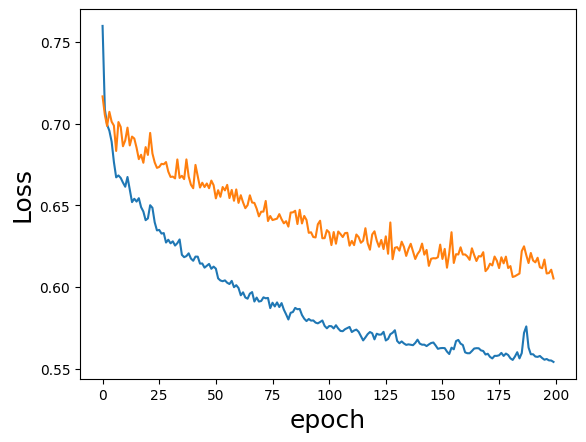

In [ ]:
#Plots
fig0=plt.figure(0)
plt.plot(train_loss_list,'-')
plt.plot(val_loss_list, '-')
plt.xlabel('epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

In [3]:
test_score = dice_score_dataset(Best_model, test_dataloader, n_classes, use_gpu=True)
print("Test DICE score: {:.4f}".format(test_score))

Test DICE score: 0.6922


# Problem 2: Transfer Learning

### Imports

In [ ]:
## Import VGG and FashionMNIST
from torchvision.models import vgg16
from torchvision.datasets import FashionMNIST
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data Loading

In [ ]:
## Specify Batch Size
train_batch_size = 32
test_batch_size = 1

# Transform data to PIL images
img_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Train/Val Subsets
train_mask = range(50000)
val_mask = range(50000, 60000)

# Download/Load Dataset
train_dataset = FashionMNIST('./data', train=True, transform=img_transform, download=True)
test_dataset = FashionMNIST('./data', train=False, transform=img_transform, download=True)

# Data Loaders
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, sampler=SubsetRandomSampler(train_mask))
val_dataloader = DataLoader(train_dataset, batch_size=test_batch_size, sampler=SubsetRandomSampler(val_mask))
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size)


# for i, data in enumerate(test_dataloader, 0):
#   inputs, targets = data
#   print(inputs.shape)
#   raise Exception
def accuracy(outputs, labels):
    with torch.no_grad():
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        return correct/total

100%|██████████| 26421880/26421880 [00:01<00:00, 16014819.37it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 267131.50it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4999177.96it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23598116.93it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
num_epochs = 10
learning_rate = 0.001

model = vgg16(pretrained=False, num_classes=10, init_weights=True).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Best_model_index = 1
Best_model_val_loss = np.inf
Best_model = None
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
print("Start Training...")
for epoch in range(num_epochs):
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    ########################### Training #####################################
    total_train_loss = 0
    train_counter = 0
    acc = 0
    for i, (X, Y) in enumerate(train_dataloader):
        train_counter += 1
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        Y_pred = model(X)
        ls = loss(Y_pred, Y)
        ls.backward()
        optimizer.step()
        acc += accuracy(Y_pred, Y)
        total_train_loss += ls.item()
    train_loss_list.append(total_train_loss/train_counter)
    train_acc_list.append(acc/train_counter)
    print("Training Loss: {:.4f}, Training Acc: {:.4f}".format(total_train_loss/train_counter, acc/train_counter))

    ########################### Validation #####################################
    total_val_loss = 0
    val_counter = 0
    with torch.no_grad():
        acc = 0
        for i, (X, Y) in enumerate(val_dataloader):
            val_counter += 1
            X = X.to(device)
            Y = Y.to(device)
            Y_pred = model(X)
            ls = loss(Y_pred, Y)
            acc += accuracy(Y_pred, Y)
            total_val_loss += ls.item()
        epoch_val_loss = total_val_loss/val_counter
        val_loss_list.append(epoch_val_loss)
        val_acc_list.append(acc/val_counter)
        print("Validation Loss: {:.4f}, Validation Acc: {:.4f}".format(epoch_val_loss, acc/val_counter))
        if epoch_val_loss < Best_model_val_loss:
            Best_model_val_loss = epoch_val_loss
            Best_model_index = epoch
            Best_model = copy.deepcopy(model)
        print('Current Best Model: Epoch {}, Best Validation Loss {:.4f}'.format(Best_model_index, Best_model_val_loss))

Start Training...

EPOCH 1 of 10

Training Loss: 0.6626, Training Acc: 0.7552
Validation Loss: 0.4678, Validation Acc: 0.8248
Current Best Model: Epoch 0, Best Validation Loss 0.4678

EPOCH 2 of 10

Training Loss: 0.3733, Training Acc: 0.8637
Validation Loss: 0.3519, Validation Acc: 0.8674
Current Best Model: Epoch 1, Best Validation Loss 0.3519

EPOCH 3 of 10

Training Loss: 0.3125, Training Acc: 0.8863
Validation Loss: 0.2935, Validation Acc: 0.8882
Current Best Model: Epoch 2, Best Validation Loss 0.2935

EPOCH 4 of 10

Training Loss: 0.2750, Training Acc: 0.8990
Validation Loss: 0.2812, Validation Acc: 0.8960
Current Best Model: Epoch 3, Best Validation Loss 0.2812

EPOCH 5 of 10

Training Loss: 0.2462, Training Acc: 0.9096
Validation Loss: 0.2722, Validation Acc: 0.8987
Current Best Model: Epoch 4, Best Validation Loss 0.2722

EPOCH 6 of 10

Training Loss: 0.2229, Training Acc: 0.9183
Validation Loss: 0.2396, Validation Acc: 0.9139
Current Best Model: Epoch 5, Best Validation Loss

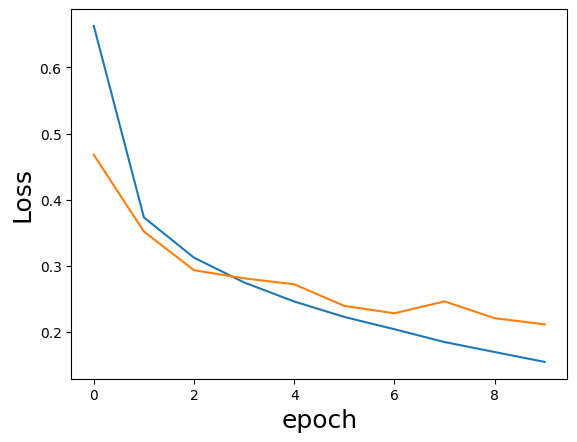

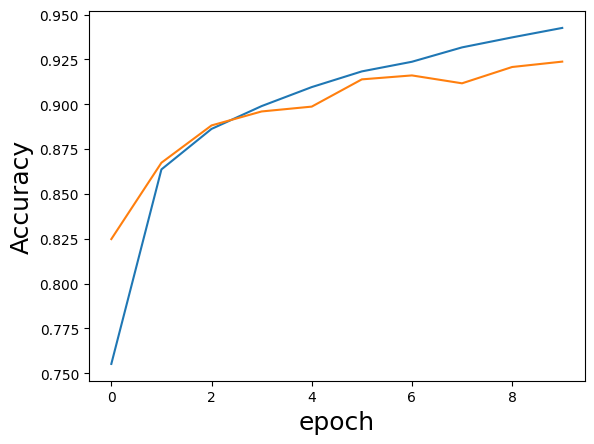

In [ ]:
#Plots
fig0=plt.figure(0)
plt.plot(train_loss_list,'-')
plt.plot(val_loss_list, '-')
plt.xlabel('epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

#Plots
fig0=plt.figure(1)
plt.plot(train_acc_list,'-')
plt.plot(new_val_acc_list, '-')
plt.xlabel('epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

In [ ]:
## Test accuracy:
test_counter = 0
test_acc = 0
test_loss = 0
for i, (X, Y) in enumerate(test_dataloader):
    test_counter += 1
    X = X.to(device)
    Y = Y.to(device)
    Y_pred = Best_model(X)
    ls = loss(Y_pred, Y)
    test_acc += accuracy(Y_pred, Y)
    test_loss += ls.item()
print("Test Accuracy: {:.4f}, Test Loss: {:.4f}".format(test_acc/test_counter, test_loss/test_counter))

Test Accuracy: 0.9209, Test Loss: 0.2286


In [ ]:
torch.save(Best_model.state_dict(), "Model_Q2a.pth")
recol_train_loss = train_loss_list
recol_val_loss = val_loss_list

In [ ]:
num_epochs = 10
learning_rate = 0.001
n_classes = 10
from torchsummary import summary

model = vgg16(pretrained=True).to(device)
#print(model)
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

n_inputs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(),
            nn.Linear(256, n_classes), nn.Softmax(dim=1))

model.to(device)
#num_features = model.classifier[6].in_features
#num_ftrs = model.fc.in_features
#summary(model, input_size=(3, 224, 224), batch_size=32, device='cuda')
#print(num_features)
#raise Exception
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Best_model_index = 1
Best_model_val_loss = np.inf
Best_model = None
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
print("Start Training...")
for epoch in range(num_epochs):
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    ########################### Training #####################################
    total_train_loss = 0
    train_counter = 0
    acc = 0
    for i, (X, Y) in enumerate(train_dataloader):
        train_counter += 1
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        Y_pred = model(X)
        ls = loss(Y_pred, Y)
        ls.backward()
        optimizer.step()
        acc += accuracy(Y_pred, Y)
        total_train_loss += ls.item()
    train_loss_list.append(total_train_loss/train_counter)
    train_acc_list.append(acc/train_counter)
    print("Training Loss: {:.4f}, Training Acc: {:.4f}".format(total_train_loss/train_counter, acc/train_counter))

    ########################### Validation #####################################
    total_val_loss = 0
    val_counter = 0
    with torch.no_grad():
        acc = 0
        for i, (X, Y) in enumerate(val_dataloader):
            val_counter += 1
            X = X.to(device)
            Y = Y.to(device)
            Y_pred = model(X)
            ls = loss(Y_pred, Y)
            acc += accuracy(Y_pred, Y)
            total_val_loss += ls.item()
        epoch_val_loss = total_val_loss/val_counter
        val_loss_list.append(epoch_val_loss)
        val_acc_list.append(acc/val_counter)
        print("Validation Loss: {:.4f}, Validation Acc: {:.4f}".format(epoch_val_loss, acc/val_counter))
        if epoch_val_loss < Best_model_val_loss:
            Best_model_val_loss = epoch_val_loss
            Best_model_index = epoch
            Best_model = copy.deepcopy(model)
        print('Current Best Model: Epoch {}, Best Validation Loss {:.4f}'.format(Best_model_index, Best_model_val_loss))

Start Training...

EPOCH 1 of 10

Training Loss: 1.9318, Training Acc: 0.6066
Validation Loss: 1.7474, Validation Acc: 0.7482
Current Best Model: Epoch 0, Best Validation Loss 1.7474

EPOCH 2 of 10

Training Loss: 1.7274, Training Acc: 0.7578
Validation Loss: 1.7159, Validation Acc: 0.7631
Current Best Model: Epoch 1, Best Validation Loss 1.7159

EPOCH 3 of 10

Training Loss: 1.7078, Training Acc: 0.7688
Validation Loss: 1.7067, Validation Acc: 0.7671
Current Best Model: Epoch 2, Best Validation Loss 1.7067

EPOCH 4 of 10

Training Loss: 1.6992, Training Acc: 0.7731
Validation Loss: 1.7007, Validation Acc: 0.7697
Current Best Model: Epoch 3, Best Validation Loss 1.7007

EPOCH 5 of 10

Training Loss: 1.6930, Training Acc: 0.7768
Validation Loss: 1.6929, Validation Acc: 0.7743
Current Best Model: Epoch 4, Best Validation Loss 1.6929

EPOCH 6 of 10

Training Loss: 1.6896, Training Acc: 0.7798
Validation Loss: 1.6905, Validation Acc: 0.7792
Current Best Model: Epoch 5, Best Validation Loss

### Model Initialization and Training/Fine-tuning

Complete the rest of the assignment in the notebook below.

In [ ]:
num_epochs = 10
learning_rate = 0.001
n_classes = 10
from torchsummary import summary

model = vgg16(pretrained=True).to(device)
#print(model)
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

n_inputs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(),
            nn.Linear(256, n_classes), nn.Softmax(dim=1))

model.to(device)
#num_features = model.classifier[6].in_features
#num_ftrs = model.fc.in_features
#summary(model, input_size=(3, 224, 224), batch_size=32, device='cuda')
#print(num_features)
#raise Exception
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Best_model_index = 1
Best_model_val_loss = np.inf
Best_model = None
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
print("Start Training...")
for epoch in range(num_epochs):
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    ########################### Training #####################################
    total_train_loss = 0
    train_counter = 0
    acc = 0
    for i, (X, Y) in enumerate(train_dataloader):
        train_counter += 1
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        Y_pred = model(X)
        ls = loss(Y_pred, Y)
        ls.backward()
        optimizer.step()
        acc += accuracy(Y_pred, Y)
        total_train_loss += ls.item()
    train_loss_list.append(total_train_loss/train_counter)
    train_acc_list.append(acc/train_counter)
    print("Training Loss: {:.4f}, Training Acc: {:.4f}".format(total_train_loss/train_counter, acc/train_counter))

    ########################### Validation #####################################
    total_val_loss = 0
    val_counter = 0
    with torch.no_grad():
        acc = 0
        for i, (X, Y) in enumerate(val_dataloader):
            val_counter += 1
            X = X.to(device)
            Y = Y.to(device)
            Y_pred = model(X)
            ls = loss(Y_pred, Y)
            acc += accuracy(Y_pred, Y)
            total_val_loss += ls.item()
        epoch_val_loss = total_val_loss/val_counter
        val_loss_list.append(epoch_val_loss)
        val_acc_list.append(acc/val_counter)
        print("Validation Loss: {:.4f}, Validation Acc: {:.4f}".format(epoch_val_loss, acc/val_counter))
        if epoch_val_loss < Best_model_val_loss:
            Best_model_val_loss = epoch_val_loss
            Best_model_index = epoch
            Best_model = copy.deepcopy(model)
        print('Current Best Model: Epoch {}, Best Validation Loss {:.4f}'.format(Best_model_index, Best_model_val_loss))

Start Training...

EPOCH 1 of 10

Training Loss: 1.9588, Training Acc: 0.5729
Validation Loss: 1.7577, Validation Acc: 0.7508
Current Best Model: Epoch 0, Best Validation Loss 1.7577

EPOCH 2 of 10

Training Loss: 1.7210, Training Acc: 0.7713
Validation Loss: 1.7024, Validation Acc: 0.7841
Current Best Model: Epoch 1, Best Validation Loss 1.7024

EPOCH 3 of 10

Training Loss: 1.6903, Training Acc: 0.7893
Validation Loss: 1.6850, Validation Acc: 0.7926
Current Best Model: Epoch 2, Best Validation Loss 1.6850

EPOCH 4 of 10

Training Loss: 1.6780, Training Acc: 0.7965
Validation Loss: 1.6786, Validation Acc: 0.7937
Current Best Model: Epoch 3, Best Validation Loss 1.6786

EPOCH 5 of 10

Training Loss: 1.6697, Training Acc: 0.8034
Validation Loss: 1.6702, Validation Acc: 0.7989
Current Best Model: Epoch 4, Best Validation Loss 1.6702

EPOCH 6 of 10

Training Loss: 1.6650, Training Acc: 0.8058
Validation Loss: 1.6676, Validation Acc: 0.8020
Current Best Model: Epoch 5, Best Validation Loss

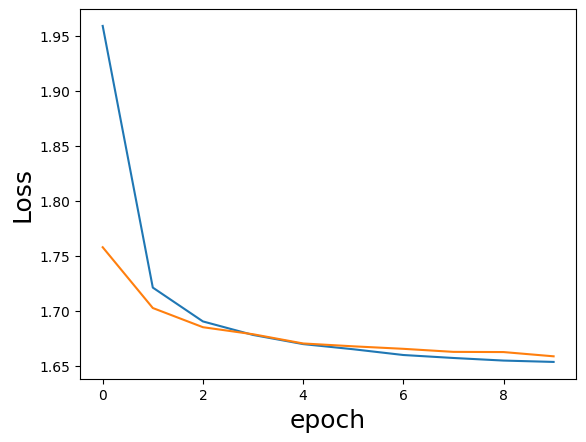

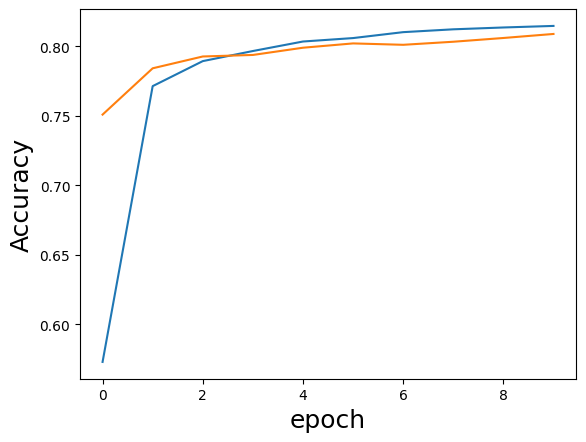

In [ ]:
#Plots
fig0=plt.figure(0)
plt.plot(train_loss_list,'-')
plt.plot(val_loss_list, '-')
plt.xlabel('epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

#Plots
fig0=plt.figure(1)
plt.plot(train_acc_list,'-')
plt.plot(val_acc_list, '-')
plt.xlabel('epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

In [ ]:
torch.save(Best_model.state_dict(), "Model_Q2b.pth")
recol_train_loss = train_loss_list
recol_val_loss = val_loss_list

In [ ]:
## Test accuracy:
test_counter = 0
test_acc = 0
test_loss = 0
for i, (X, Y) in enumerate(test_dataloader):
    test_counter += 1
    X = X.to(device)
    Y = Y.to(device)
    Y_pred = Best_model(X)
    ls = loss(Y_pred, Y)
    test_acc += accuracy(Y_pred, Y)
    test_loss += ls.item()
print("Test Accuracy: {:.4f}, Test Loss: {:.4f}".format(test_acc/test_counter, test_loss/test_counter))

Test Accuracy: 0.8009, Test Loss: 1.6653
